# Tecnológico de Monterrey

## MR4010 Navegación autónoma

## Dr. David Antonio-Torres

### Actividad 2.1 - Detección de carriles en video usando transformada de Hough

#### Emmanuel Domínguez Bravo A01793683
#### Maximiliano Morones Gómez 
#### Saúl Yovani Salgueiro Lindoro
#### Gerardo Quiroga Nájera

In [96]:
# Se cargan las bibliotecas necesarias

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [87]:
# Se cargan los frames del video en escala de grises y se obtienen los bordes con *Canny*
def plot_image(img):
    image = cv2.imread(img)
    img_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_canny = cv2.Canny(img_grey, 40, 120) 
    img_arr = np.asarray(img_grey)
    plt.imshow(img_canny, cmap='gray')

In [88]:
ROI_vertices = np.array([[(0,1300),(1100, 1000), (1300, 1000), (1550,1300)]], dtype=np.int32)

img_roi = np.zeros_like(img_grey)
cv2.fillPoly(img_roi, ROI_vertices, 255)
#img_mask = cv2.bitwise_and(img_canny, img_roi)
img_con_roi = cv2.bitwise_and(img_grey, img_roi)
#plt.imshow(img_con_roi, cmap='gray')

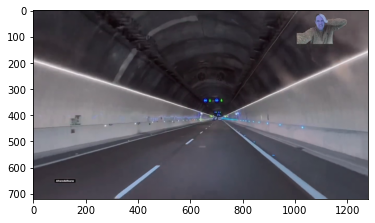

In [89]:
# Se carga el archivo MP4 y se accede a cada uno de los frames
# iteramos el proceso de graficar las líneas sobre cada frame

cap = cv2.VideoCapture('test.MP4')
width = 1000
height = 600

ret, frame = cap.read()
#if ret:
#frame = cv2.resize (frame, (width, height))
#frame = process(frame)

#cv2.imshow('video', frame)

#if cv2.waitKey(1) == 13:
 #   break

#cap.release()
#cv2.destroyAllWindows()
plt.imshow(frame, cmap='gray')

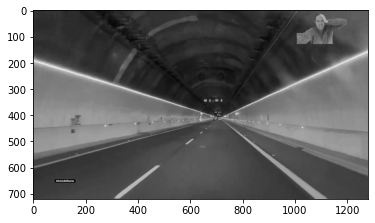

In [90]:
image = frame
img_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_canny = cv2.Canny(img_grey, 40, 120) 
img_arr = np.asarray(img_grey)
plt.imshow(img_grey, cmap='gray')

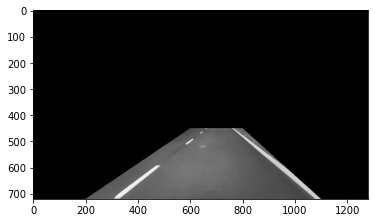

In [93]:
#ROI_vertices = np.array([[(0,600),(650, 450), (750, 450), (1050,0)]], dtype=np.int32)
ROI_vertices = np.array([[(200,720),(600, 450), (800, 450), (1100,720)]], dtype=np.int32)

img_roi = np.zeros_like(img_grey)
cv2.fillPoly(img_roi, ROI_vertices, 255)
img_con_roi = cv2.bitwise_and(img_grey, img_roi)
plt.imshow(img_con_roi, cmap='gray')

In [101]:
def process(image):

    # Se cargan los frames del video en escala de grises y se obtienen los bordes con *Canny*
    
    img_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_canny = cv2.Canny(img_grey, 40, 120) 

    # Se crea la ROI
    
    height = img_grey.shape[0]
    width = img_grey.shape[1]

    #ROI_vertices = np.array([[
     #   (0,height),
      #  (width/3, height/2),
       # (width*2/3, height/2),
        #(0,height)
    #]], dtype=np.int32)
    
    
    #ROI_vertices = np.array([[(0,1300),(1100,1000),(1300,1000),(1500,1300)]], dtype=np.int32)
    ROI_vertices = np.array([[(200,720),(600, 450), (800, 450), (1100,720)]], dtype=np.int32)
    
    # Se aplica la ROI al frame en escala de grises que resulta de aplicar Canny
    
    img_roi = np.zeros_like(img_canny)
    cv2.fillPoly(img_roi, ROI_vertices, 255)
    img_mask = cv2.bitwise_and(img_canny, img_roi)
    
    rho = 2            # resolución de rho en pixeles
    theta = np.pi/180  # resolución de theta en radianes 
    threshold = 20     # mínimo número de votos para ser considerado una línea 
    min_line_len = 20  # mínimo número de pixeles para que se forme una línea
    max_line_gap = 20  # máximo espacio en pixeles entre segmentos de línea    
    lines = cv2.HoughLinesP(img_mask, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    
    # se crea un fondo negro del tamaño de la imagen con bordes
    img_lines = np.zeros((img_mask.shape[0], img_mask.shape[1], 3), dtype=np.uint8)
    # se dibujan cada una de las líneas sobre la imagen con fondo negro    
    
    for line in lines:
        for x1,y1,x2,y2 in line:      
            cv2.line(img_lines, (x1, y1), (x2, y2), [255, 0, 0], 30)
        
    #Usando la función *addWeighted* se hace una combinación de la imagen a color original y las
    #líneas encontradas por la Transformada de Hough
    alpha = 1
    beta = 1
    gamma = 1
    img_lane_lines = cv2.addWeighted(image, alpha, img_lines, beta, gamma)
    
    return img_lane_lines



In [102]:
# Se carga el archivo MP4 y se accede a cada uno de los frames
# iteramos el proceso de graficar las líneas sobre cada frame

cap = cv2.VideoCapture('test.MP4')
width = 1000
height = 600

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        frame = cv2.resize (frame, (width, height))
        frame = process(frame)
        cv2.imshow('video', frame)
        if cv2.waitKey(1) == 13:
            break

cap.release()
cv2.destroyAllWindows()